# Downloading Data and Extracting it to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Oxford Pet Dataset

In [ ]:
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz

--2023-04-17 13:08:50--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz [following]
--2023-04-17 13:08:50--  https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  29.6MB/s    in 28s     

2023-04-17 13:09:18 (27.4 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]



In [ ]:
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz

--2023-04-18 11:01:18--  https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz [following]
--2023-04-18 11:01:19--  https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/octet-stream]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  15.5MB/s    in 1.2s    

2023-04-18 11:01:20 (15.5 MB/s) - ‘annotations.tar.gz’ saved [19173078/19173078]



In [ ]:
!cp /content/images.tar.gz /content/drive/MyDrive/DL_DATA/LAB 


In [ ]:
!cp /content/annotations.tar.gz /content/drive/MyDrive/DL_DATA/LAB 


In [ ]:
!tar xvzf /content/drive/MyDrive/DL_DATA/LAB/images.tar.gz -C /content/drive/MyDrive/DL_DATA/LAB/


In [ ]:
!tar xvzf /content/drive/MyDrive/DL_DATA/LAB/annotations.tar.gz -C /content/drive/MyDrive/DL_DATA/LAB/


# Image Segmenatation on Oxford Data

## Libraries

In [ ]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import numpy as np

##Unet Model

### Defining Model

In [ ]:
def convolution_operation(entered_input, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)
    
    # Taking first input and implementing the second conv block
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)
    
    return act2

In [ ]:
def encoder(entered_input, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1

In [ ]:
def decoder(entered_input, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out

In [ ]:
def U_Net(Image_Size):
    # Take the image size and shape
    input1 = Input(Image_Size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    out = Conv2D(1, 1, padding="same", activation="sigmoid")(decoder_4)

    model = Model(input1, out)
    return model

In [ ]:
input_shape = (160, 160, 3)
model = U_Net(input_shape)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 160, 160, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 160, 160, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                           

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

### Data Preprocessing

In [ ]:
train_data_dir = '/content/drive/MyDrive/DL_DATA/Images'
train_masks_dir = '/content/drive/MyDrive/DL_DATA/LAB/annotations/trimaps'
train_data = []
train_masks = []


In [ ]:
def preprocess(image):
    image = cv2.resize(image, (160, 160))
    image = image / 255.0
    
    return image

def preprocess_mask(mask):
    mask = cv2.resize(mask, (160, 160))
    mask = np.where(mask > 0, 1, 0)
    
    return mask


In [ ]:
for filename in os.listdir(train_data_dir):
    img_path = os.path.join(train_data_dir, filename)
    mask_path = os.path.join(train_masks_dir, filename + '.png')
    train_data.append(img_path)
    train_masks.append(mask_path)

train_data_preprocessed = []
train_masks_preprocessed = []


In [ ]:
s=cv2.imread(train_masks[0])
print(s)

None


In [ ]:
for i in range(len(train_data)):
    img = cv2.imread(train_data[i])
    mask = cv2.imread(train_masks[i], cv2.IMREAD_GRAYSCALE)
    train_data_preprocessed.append(preprocess(img))
    train_masks_preprocessed.append(preprocess_mask(mask))

train_data_preprocessed = np.array(train_data_preprocessed)
train_masks_preprocessed = np.array(train_masks_preprocessed)


error: ignored

### Model Training

In [ ]:
model.fit(train_data_preprocessed, train_masks_preprocessed, batch_size=32, epochs=10)

# Transfer Learning on CIFAR 10 

## Importing Libraries and Data Preprocessing

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Input,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras import optimizers
import matplotlib.pyplot as plt
import cv2
import numpy as np


In [ ]:
def normalize(X_train,X_test):
        #this function normalize inputs for zero mean and unit variance
        # it is used when training a model.
        # Input: training set and test set
        # Output: normalized training set and test set according to the trianing set statistics.
        mean = np.mean(X_train,axis=(0,1,2,3))
        std = np.std(X_train, axis=(0, 1, 2, 3))
        X_train = (X_train-mean)/(std+1e-7)
        X_test = (X_test-mean)/(std+1e-7)
        return X_train, X_test

In [ ]:

(x_train, y_train), (x_test, y_test) = cifar10.load_data()



x_train = x_train.astype('float32') 
x_test = x_test.astype('float32') 
x_train, x_test = normalize(x_train, x_test)


y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)


In [ ]:
print(x_train.shape)

(50000, 32, 32, 3)


In [ ]:
learning_rate = 1e-2
lr_decay = 1e-6

## VGG-16

In [ ]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in vgg_model.layers:
    layer.trainable = False

inputs = Input(shape=(32, 32, 3))
x = vgg_model(inputs)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)
# Compile the model
early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)
ssgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
model.compile(optimizer=ssgd, loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
history= model.fit(x_train, y_train, epochs=100, batch_size=64,validation_split=0.2, callbacks=[early_stop])


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
625/625 [==============================] - 18s 15ms/step - loss: 1.2345 - accuracy: 0.5689 - val_loss: 1.0960 - val_accuracy: 0.6198
Epoch 2/100
625/625 [==============================] - 9s 15ms/step - loss: 1.0472 - accuracy: 0.6338 - val_loss: 1.0534 - val_accuracy: 0.6351
Epoch 3/100
625/625 [==============================] - 9s 15ms/step - loss: 0.9890 - accuracy: 0.6544 - val_loss: 1.0215 - val_accuracy: 0.6438
Epoch 4/100
625/625 [==============================] - 9s 15ms/step - loss: 0.9469 - accuracy: 0.6686 - val_loss: 1.0144 - val_accuracy: 0.6488
Epoch 5/100
625/625 [==============================] - 9s 14ms/step - loss: 0.9112 - accuracy: 0.6803 - val_loss: 0.9890 - val_accuracy: 0.6563
Epoch 6/100
625/625 [==============================] - 9s 15ms/step - loss: 0.8765 - accuracy: 0.6917 - val_loss: 1.0134 - val_accuracy: 0.6467
Epoch 7/100
625/625 [==============================] - 9s 14ms/step - loss: 0.8468 - accuracy: 0.7020 - val_loss: 0.9730 - val_accuracy

In [ ]:

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9645287394523621
Test accuracy: 0.6650000214576721


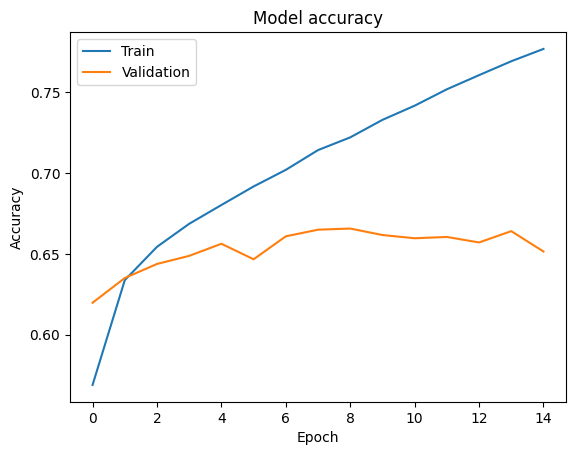

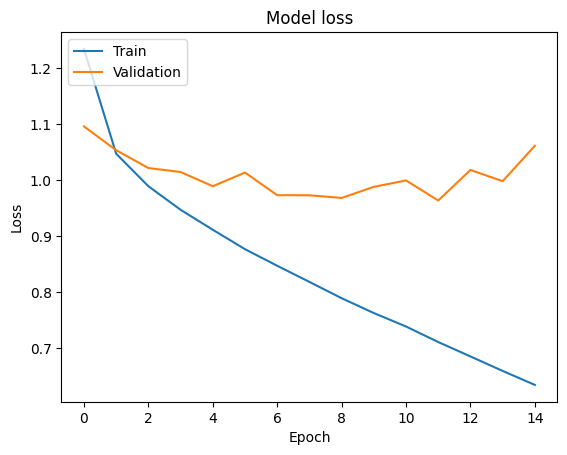

In [ ]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## ResNet50

In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in resnet_model.layers:
    layer.trainable = False

inputs = Input(shape=(32, 32, 3))
x = resnet_model(inputs)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
ssgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
model.compile(optimizer=ssgd, loss='categorical_crossentropy', metrics=['accuracy'])

history=model.fit(x_train, y_train, epochs=100, batch_size=64,validation_split=0.2,callbacks=[early_stop])


Epoch 1/100
625/625 [==============================] - 15s 18ms/step - loss: 1.8848 - accuracy: 0.3202 - val_loss: 1.7434 - val_accuracy: 0.3749
Epoch 2/100
625/625 [==============================] - 10s 16ms/step - loss: 1.7307 - accuracy: 0.3767 - val_loss: 1.6993 - val_accuracy: 0.3868
Epoch 3/100
625/625 [==============================] - 9s 15ms/step - loss: 1.6849 - accuracy: 0.3948 - val_loss: 1.6430 - val_accuracy: 0.4060
Epoch 4/100
625/625 [==============================] - 10s 16ms/step - loss: 1.6632 - accuracy: 0.4095 - val_loss: 1.6570 - val_accuracy: 0.4111
Epoch 5/100
625/625 [==============================] - 9s 14ms/step - loss: 1.6399 - accuracy: 0.4169 - val_loss: 1.6446 - val_accuracy: 0.4181
Epoch 6/100
625/625 [==============================] - 9s 15ms/step - loss: 1.6281 - accuracy: 0.4199 - val_loss: 1.6604 - val_accuracy: 0.4123
Epoch 7/100
625/625 [==============================] - 9s 15ms/step - loss: 1.6124 - accuracy: 0.4273 - val_loss: 1.5917 - val_accura

In [ ]:

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.5895646810531616
Test accuracy: 0.43560001254081726


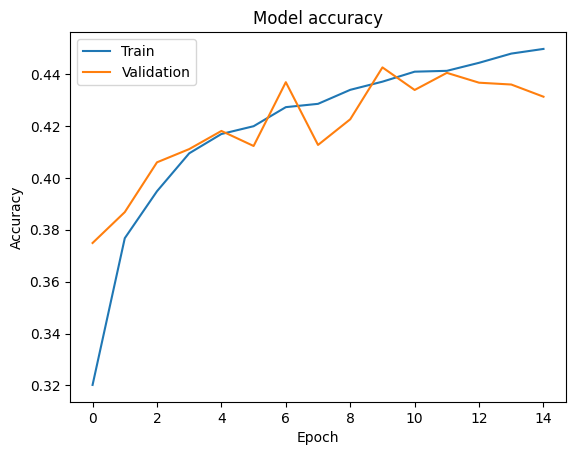

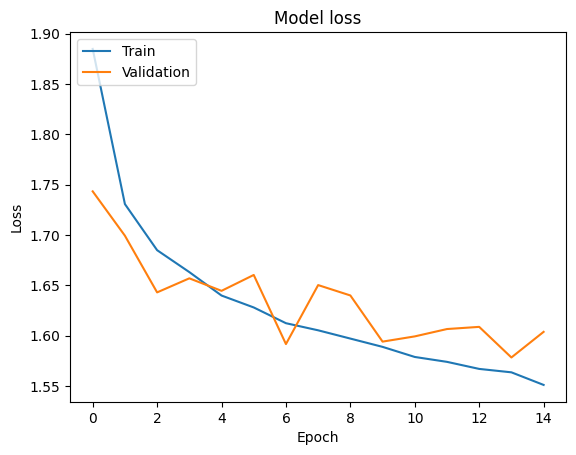

In [ ]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Densenet

In [ ]:
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in densenet_model.layers:
    layer.trainable = False

inputs = Input(shape=(32, 32, 3))
x = densenet_model(inputs)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
ssgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
model.compile(optimizer=ssgd, loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit(x_train, y_train, epochs=100, batch_size=64,validation_split=0.2,callbacks=[early_stop])


Epoch 1/100
625/625 [==============================] - 25s 28ms/step - loss: 1.1070 - accuracy: 0.6117 - val_loss: 0.9886 - val_accuracy: 0.6515
Epoch 2/100
625/625 [==============================] - 12s 19ms/step - loss: 0.8956 - accuracy: 0.6823 - val_loss: 0.9533 - val_accuracy: 0.6684
Epoch 3/100
625/625 [==============================] - 11s 18ms/step - loss: 0.8051 - accuracy: 0.7145 - val_loss: 0.9375 - val_accuracy: 0.6735
Epoch 4/100
625/625 [==============================] - 11s 17ms/step - loss: 0.7302 - accuracy: 0.7423 - val_loss: 0.9721 - val_accuracy: 0.6716
Epoch 5/100
625/625 [==============================] - 11s 17ms/step - loss: 0.6616 - accuracy: 0.7640 - val_loss: 0.9342 - val_accuracy: 0.6843
Epoch 6/100
625/625 [==============================] - 11s 17ms/step - loss: 0.5947 - accuracy: 0.7884 - val_loss: 0.9566 - val_accuracy: 0.6847
Epoch 7/100
625/625 [==============================] - 14s 22ms/step - loss: 0.5329 - accuracy: 0.8102 - val_loss: 1.0054 - val_ac

In [ ]:
# Evaluate the model
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.973611056804657
Test accuracy: 0.6784999966621399


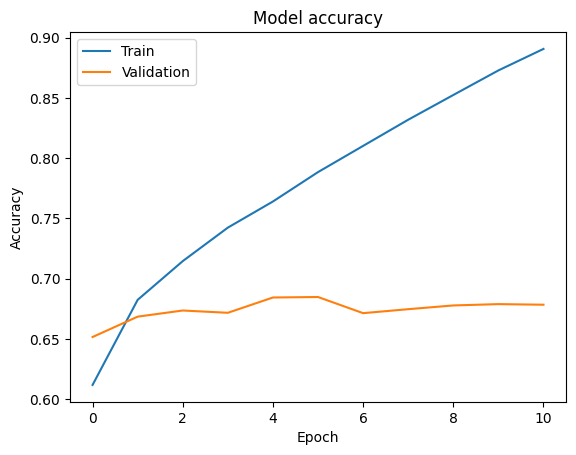

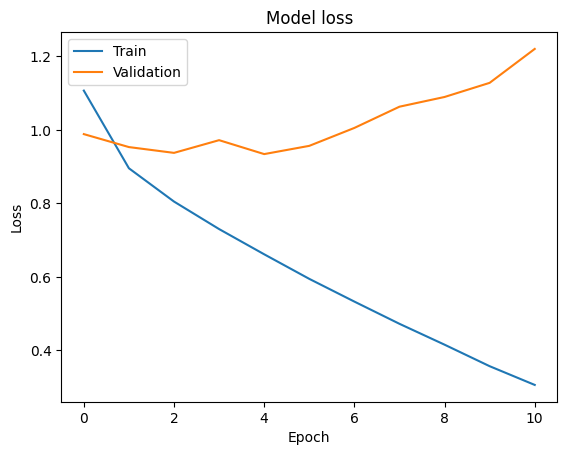

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Use Apparel images dataset and train multiple output CNN model to classify each dress image's category and color

## Importing Libraries and Data

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

In [ ]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [ ]:
(x_train, y_train), (x_test, y_test) =  # Dataset Missing
 

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


y_train_category = to_categorical(y_train[:,0])
y_train_color = to_categorical(y_train[:,1])
y_test_category = to_categorical(y_test[:,0])
y_test_color = to_categorical(y_test[:,1])

## CNN model 

In [ ]:
inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output_category = Dense(10, activation='softmax', name='category')(x)
output_color = Dense(10, activation='softmax', name='color')(x)

# Compile the model
model = Model(inputs=inputs, outputs=[output_category, output_color])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.fit(x_train, [y_train_category, y_train_color], epochs=10, batch_size=64, validation_split=0.2)


In [ ]:
score = model.evaluate(x_test, [y_test_category, y_test_color], verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])